# KarriereAI
#### A deep learning model used to predict viable career paths to a user based on their skills and interests.

#### Purpose
KarriereAI will classify the appropriate career within technology for a user from an interactive quizlet input. The quizlet is used to determine the user's skills and interests, before the model will predict a fitting career based on the input data.

#### Dataset
The dataset to be used is from the paper Skill2vec: A Machine Learning Approach for Determining the Relevant Skills from Job Description, by Van-Duyet Le et al. <a href="https://arxiv.org/pdf/1707.09751">here</a>. Containing relevant columns of job titles related to a free-text field of job descriptions describing relevant skills. 

#### Model Architecture
The main model is a feed-forward neural network (FNN) for classification, using a multi-layer-perceptron (MLP) architecture suitable for structured data classification. 

Part of engineering the main model requires preprocessing of the dataset in a natural language processing (NLP) set-up, preparing it to run through a sub-model with an encoded transformer architecture.

The main model also requires figuring out basic vs. deep MLP architecures. Additionally, figuring out whether the model should contain batch normalization, regularization and/or dropout. Lastly, experimenting with different activation functions.

Through using the NLP sub-model, the data will be vectorized to work with the MLP classifier rather than the language model.

#### Evaluation
As far as evaluation goes, a confusion matrix and an F1 score will be computed along with standard evaluation metrics like accuracy, recall and precision.

### Step 1 - Importing Libraries and Loading the Data 
We will be needing different libraries from <a href="https://keras.io/api/">Keras</a> and <a href="https://www.tensorflow.org/api_docs/python/tf">TensorFlow</a> among others to make computations on the dataset.

In [1]:
# Model processing
import pandas
import tensorflow
import keras

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from keras import layers, Sequential, Input

# Other
import datetime

# For plotting
%matplotlib inline
import matplotlib as plot
import matplotlib.pyplot as pyplot

import seaborn
seaborn.set_theme (style = "whitegrid")

%load_ext tensorboard

After importing relevant libraries, we load the dataset we wish to train the model on.

In [2]:
# Load dataset
data = pandas.read_csv ("data/mustHaveSkills.csv", header = 0, encoding ='ISO-8859-1')

# REF: Van-Duyet Le

### Step 2 - Taking a Look at the Data

To create optimal and smooth-running Python for the model we want to  study the shape of the data.

In [3]:
# Basic information about dataset
print ("Shape of dataset:", data.shape, "\n")
print ("Information about dataset:")
data.info()

Shape of dataset: (261724, 3) 

Information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261724 entries, 0 to 261723
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   job_brief_id  261724 non-null  int64 
 1   keyword_name  261717 non-null  object
 2   job_title     261724 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


#### 1.1 String Cleanup

In [4]:
# String magic
data ['keyword_name'] = data ['keyword_name'].str.lower()
data ['job_title'] = data ['job_title'].str.lower()

# Drop duplicates
data = data [data ["job_title"] != 0]
print (data.info())

# REF: Van-Duyet Le

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261724 entries, 0 to 261723
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   job_brief_id  261724 non-null  int64 
 1   keyword_name  261717 non-null  object
 2   job_title     261724 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.0+ MB
None


### Step 3 - Exploratory Data Analysis (EDA)

To know what data the model will injest, taking a closer look by constructing plots and 

#### 3.1 Plotting Jobs and Skills
##### 3.1.1 Jobs

In [5]:
# Function to count number of occurrences 
def count_items(series):
    items = series.dropna().apply(lambda x: x.split(";"))
    flat_list = [item.strip() for sublist in items for item in sublist]
    return pandas.Series(flat_list).value_counts()

# REF: Adil Shamim

In [6]:
# Count Jobs
job_count = count_items(data["job_title"])
print("Most Common Jobs:\n", job_count)

Most Common Jobs:
 software engineer                         8765
software developer                        5098
engineer                                  3616
manager                                   2824
developer                                 2454
                                          ... 
statistical programer                        1
commercial finance manager                   1
campus manager                               1
level manger or director or consultant       1
quality assurance or quality                 1
Name: count, Length: 4597, dtype: int64


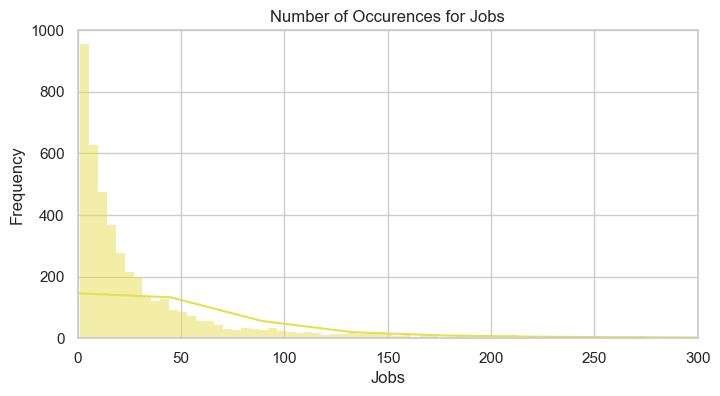

In [7]:
# Plot count for jobs
pyplot.figure (figsize = (8, 4))
seaborn.histplot (job_count, kde = True, color = "#e7de50")
pyplot.title ("Number of Occurences for Jobs")
pyplot.xlabel ("Jobs")
pyplot.ylabel ("Frequency")
pyplot.xlim((0, 300))
pyplot.ylim((0, 1000))
pyplot.show ()

##### 3.1.2 Skills

In [8]:
# Count Skills
skills_count = count_items(data["keyword_name"])
print("Most Common Skills:\n", skills_count)

Most Common Skills:
 java                                                          4588
c++                                                           3193
j2ee                                                          2255
python                                                        2177
javascript                                                    2004
                                                              ... 
phr/sphr                                                         1
business partners                                                1
operations manager                                               1
t24                                                              1
(quality or qe) and (electrical or mechanical or software)       1
Name: count, Length: 6876, dtype: int64


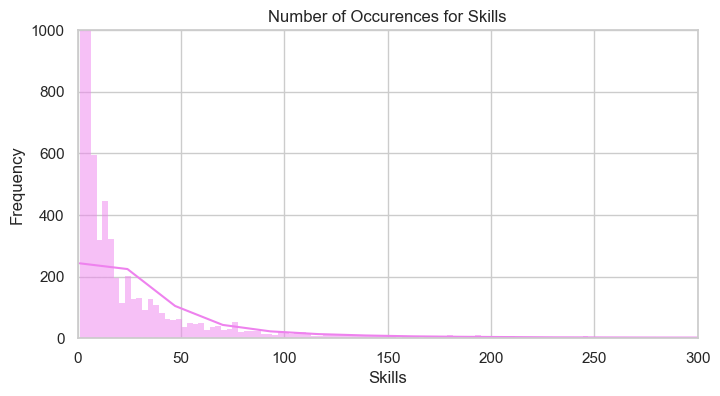

In [9]:
# Plot count for skills
pyplot.figure (figsize = (8, 4))
seaborn.histplot (skills_count, kde = True, color = "violet")
pyplot.title ("Number of Occurences for Skills")
pyplot.xlabel ("Skills")
pyplot.ylabel ("Frequency")
pyplot.xlim((0, 300))
pyplot.ylim((0, 1000))
pyplot.show ()

In [10]:
# Display skills count
skills_count

java                                                          4588
c++                                                           3193
j2ee                                                          2255
python                                                        2177
javascript                                                    2004
                                                              ... 
phr/sphr                                                         1
business partners                                                1
operations manager                                               1
t24                                                              1
(quality or qe) and (electrical or mechanical or software)       1
Name: count, Length: 6876, dtype: int64

### Step 4: Preprocessing of Data

For the purpose of cleaning the dataset to make sure the model doesn't learn errors making predictions skewed.

#### 4.1 Normalization
Normalizing the job titles with less occurrences than an input threshold.

In [11]:
# Remove jobs below threshold of top 100
job_count = job_count.iloc[0:100]
print ("Job Count")
print (job_count)

Job Count
software engineer         8765
software developer        5098
engineer                  3616
manager                   2824
developer                 2454
                          ... 
statistical programmer     407
ctm                        406
staff engineer             405
senior manager             396
automation engineer        394
Name: count, Length: 100, dtype: int64


In [12]:
# Remove skills for jobs below threshold of top 100
skills_count = skills_count.iloc[0:100]
print ("Skill Count")
print (skills_count)

Skill Count
java                4588
c++                 3193
j2ee                2255
python              2177
javascript          2004
                    ... 
automation           362
e-commerce           354
computer science     352
english              349
consulting           348
Name: count, Length: 100, dtype: int64


In [13]:
# Trimming the data to only keep the most common job titles
data = data [data ['job_title'].isin (job_count.keys())]
data

,job_brief_id,keyword_name,job_title
1,4,php,web developer
4,4,php,product manager
8,4,html,web developer
11,4,html,product manager
15,4,css,web developer
...,...,...,...
261713,12835,c,software engineer
261716,12835,c++,software developer
261717,12835,c++,software engineer
261720,12835,c#,software developer


In [14]:
# Trimming the data to only keep the most common skills
data = data [data ['keyword_name'].isin (skills_count.keys())]
data

,job_brief_id,keyword_name,job_title
8,4,html,web developer
11,4,html,product manager
15,4,css,web developer
18,4,css,product manager
22,4,mysql,web developer
...,...,...,...
261713,12835,c,software engineer
261716,12835,c++,software developer
261717,12835,c++,software engineer
261720,12835,c#,software developer


In [15]:
# Setup for Usable Data
dataset = data.groupby (['job_brief_id', 'job_title'])['keyword_name'].apply(list)
print (dataset.head())

job_brief_id  job_title      
4             product manager                                   [html, css, mysql]
              web developer                                     [html, css, mysql]
6             architect          [java, j2ee, jee, j2me, javase, javaee, javame...
              consultant         [java, j2ee, jee, j2me, javase, javaee, javame...
              developer          [java, j2ee, jee, j2me, javase, javaee, javame...
Name: keyword_name, dtype: object


In [16]:
# # Drop the id column which is unnecessary for training
dataframe = dataset.droplevel(0)

# Turn this into the correct type
dataframe = dataframe.to_frame("skills")
dataframe = dataframe.reset_index()
dataframe

,job_title,skills
0,product manager,"[html, css, mysql]"
1,web developer,"[html, css, mysql]"
2,architect,"[java, j2ee, jee, j2me, javase, javaee, javame..."
3,consultant,"[java, j2ee, jee, j2me, javase, javaee, javame..."
4,developer,"[java, j2ee, jee, j2me, javase, javaee, javame..."
...,...,...
10478,quality assurance,"[test, python, c++]"
10479,quality engineer,"[test, python, c++]"
10480,account manager,[sales]
10481,software developer,"[c, c++, c#]"


#### 4.2 Encoding Input

Encoding the input for the model, turning text values into numerical values for processing.

In [17]:
# Store jobs and skills in lists
skills_list = skills_count.keys ().to_list ()
titles_list = job_count.keys ().to_list ()

# Methods to map skills and jobs to an index
def map_skills_to_index (skills):
    return list (map (lambda skill: skills_list.index(skill), skills))

def map_title_to_index (title):
    return titles_list.index(title)

In [18]:
# Method to update the string values to indices, matching the skills and titles
def update_values(row):
    if isinstance(row, str):
        return map_title_to_index(row)
    else:
        return map_skills_to_index(row)

dataframe = dataframe.map(update_values) 

dataframe

,job_title,skills
0,17,"[23, 20, 76]"
1,46,"[23, 20, 76]"
2,29,"[0, 2, 5, 10, 11, 32, 12, 31, 1, 13]"
3,5,"[0, 2, 5, 10, 11, 32, 12, 31, 1, 13]"
4,4,"[0, 2, 5, 10, 11, 32, 12, 31, 1, 13]"
...,...,...
10478,28,"[93, 3, 1]"
10479,53,"[93, 3, 1]"
10480,19,[22]
10481,1,"[13, 1, 8]"


In [19]:
# Defining the encoder for the skills
encoder = keras.layers.CategoryEncoding (
    num_tokens = skills_count.count(),
    output_mode = "multi_hot", 
)

In [20]:
# Running the encoder
feature_names = ["job_title", "skills"]

def encode_skills(row):
    return encoder(row).numpy()

feature_skills = list(map(encode_skills, dataframe["skills"].to_list()))
feature_skills

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 

### Step 5 - Building the Model

Building the FFN model, and training it.

#### 5.1 Training, Validation and Test Sets

In [21]:
# Defining the preprocessed skills and titles
feature_titles = dataframe["job_title"]

dataframe_skills = pandas.DataFrame(data = feature_skills)
dataframe_titles = pandas.DataFrame(data = feature_titles)

# Combining it all into a dataframe with columns for each skill
model_dataframe = dataframe_titles.merge(dataframe_skills, left_index=True, right_index=True)
model_dataframe

,job_title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10478,28,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10479,53,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10480,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10481,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split (dataframe_skills, dataframe_titles, test_size = 0.3, random_state = 42)

#### 5.2 Training the Model

In [ ]:
# Building the model
model = Sequential([
    Input (shape = (100, )),
    layers.Dropout (0.4),
    layers.Dense (400, activation = 'relu'),
    layers.Dropout (0.05),
    layers.Dense (400, activation = 'relu'),
    layers.Dropout (0.02), 
    layers.Dense (100, activation = 'sigmoid'),
])

# Compiling definitions
model.compile (loss = 'hinge', 
              optimizer = 'adam', 
              metrics = ['accuracy', 'precision', 'recall'])

# Logging metrics for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard (log_dir = log_dir, histogram_freq = 1)

# Training the model
epochs = 30
history = model.fit (X_train, y_train,
          epochs = epochs, 
          batch_size = 1, 
          validation_split = 0.2,
          callbacks = [tensorboard_callback])

Epoch 1/30
5870/5870 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.0063 - loss: 0.1566 - precision: 0.9219 - val_accuracy: 0.0109 - val_loss: 0.1685 - val_precision: 0.9342
Epoch 2/30
5870/5870 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.0098 - loss: 0.1656 - precision: 0.9476 - val_accuracy: 0.0034 - val_loss: 0.1686 - val_precision: 0.9487
Epoch 3/30
5870/5870 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.0082 - loss: 0.1607 - precision: 0.9409 - val_accuracy: 0.0089 - val_loss: 0.1687 - val_precision: 0.9338
Epoch 4/30
5870/5870 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.0087 - loss: 0.1629 - precision: 0.9364 - val_accuracy: 0.0123 - val_loss: 0.1670 - val_precision: 0.9575
Epoch 5/30
5870/5870 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.0128 - loss: 0.1551 - precision: 0.9503 - val_accuracy: 0.0123 - val_loss: 0.1680 - val_precision: 0.9533
Epoch 6/30
5870/5870 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.0061 - loss: 0.1658 - precision: 0.9390 - val_accuracy: 

Producing a summary of the model, we get a description of its architecture and parameter layout.

In [25]:
# A summary of the models architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 400)            │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        40,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,702 (2.76 MB)

 Trainable params: 240,900 (941.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 481,802 (1.84 MB)

In [26]:
# Viewing the metrics prepared in TensorBoard
# # %tensorboard --logdir logs/fit

### Step 6 - Evaluation
To illustrate the model's performance when predicting new outcomes, we use metrics like a confusion matrix fitting for classification, combined with standard metrics like accuracy.

#### 6.1 Confusion Matrix

In [27]:
# Prediction on the test set
y_prediction = model.predict (X_test)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [28]:
# Confusion matrix
confusion_matrix = confusion_matrix (y_test, y_prediction)
plot.figure (figsize = (10, 8))
seaborn.heatmap (confusion_matrix, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = titles_list,
            yticklabels = titles_list)
plot.xlabel ("Predicted")
plot.ylabel ("Actual")
plot.title ("Confusion Matrix")
plot.show ()

# REF: Adil Shamim

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

#### 6.2 Precision, Accuracy, Recall

In [29]:
# Displaying the epochs
epochs_range = range(epochs)

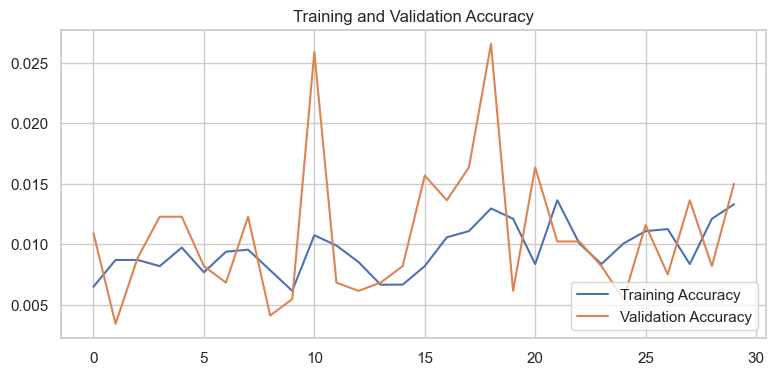

In [ ]:
# Accuracy on training and validation data
accuracy = history.history ['accuracy']
validation_accuracy = history.history ['val_accuracy']

# Plotting accuracy
pyplot.figure (figsize = (20, 4))
pyplot.subplot (1, 2, 1)
pyplot.plot (epochs_range, accuracy, label = 'Training Accuracy')
pyplot.plot (epochs_range, validation_accuracy, label = 'Validation Accuracy')
pyplot.legend (loc = 'lower right')
pyplot.title ('Training and Validation Accuracy')

pyplot.show ()

# REF: Fruitoo 

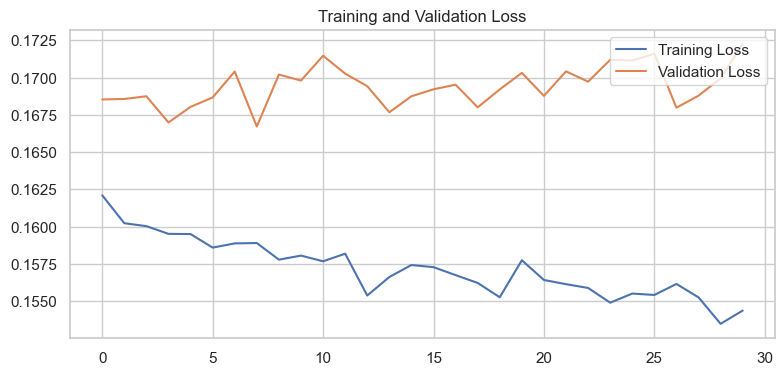

In [ ]:
# Loss on training and validation data
loss = history.history ['loss']
validation_loss = history.history ['val_loss']

# Plotting loss
pyplot.figure (figsize = (20, 4))
pyplot.subplot (1, 2, 2)
pyplot.plot (epochs_range, loss, label = 'Training Loss')
pyplot.plot (epochs_range, validation_loss, label = 'Validation Loss')
pyplot.legend (loc = 'upper right')
pyplot.title ('Training and Validation Loss')

pyplot.show ()

# REF: Fruitoo 

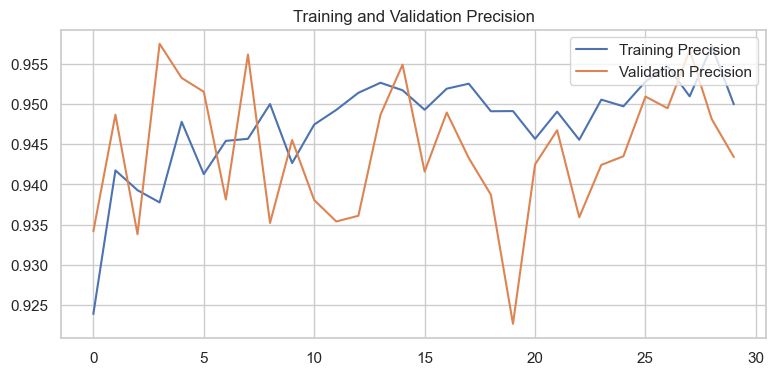

In [ ]:
# Precision on training and validation data
precision = history.history ['precision']
validation_precision = history.history ['val_precision']

# Plotting loss
pyplot.figure (figsize = (20, 4))
pyplot.subplot (1, 2, 2)
pyplot.plot (epochs_range, precision, label = 'Training Precision')
pyplot.plot (epochs_range, validation_precision, label = 'Validation Precision')
pyplot.legend (loc = 'upper right')
pyplot.title ('Training and Validation Precision')

pyplot.show ()

# REF: Fruitoo 

#### 6.3 F1-Score

In [54]:
f1_score (y_test, y_prediction, average = None)
print (f1_score)

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets